# CartPole-v0 车杆游戏
#### 问题背景：
游戏中有一辆小车，车上有一根竖直放置的棍子，每轮重置时的初始状态会有所不同，小车则需要通过左右移动来保持杆子竖直，保持游戏继续进行需要满足：

* 杆子倾斜角度$\theta<15^{\circ}$
* 小车可以移动的位置在一定范围内（中间位置到两边各有2.4个单位长度）

#### 动作action：

* 左移0
* 右移1

#### 状态变量state variables：

* x: 小车在轨道上的位置
* $\theta$：杆子与竖直方向的夹角
* $\hat{x}$：小车速度
* $\hat{\theta}$: 角度变化率

#### 游戏奖励reward：

在gym的CartPole环境env中，左移或者右移小车的策略之后，env会返回+1的reward，其中CartPole-v0中达到200个reward，则游戏结束。

#### 强化学习方法：

在本游戏背景下，使用**Q-learning**和**SARSA**两种方法，并进行对比分析。

## 1. gym接口环境配置

In [1]:
! pip install gym
! git clone https://github.com/openai/gym  

  Using cached gym-0.26.1-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached importlib_metadata-4.12.0-py3-none-any.whl (21 kB)
  Using cached zipp-3.8.1-py3-none-any.whl (5.6 kB)
Cloning into 'gym'...
remote: Enumerating objects: 16444, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 16444 (delta 182), reused 185 (delta 112), pack-reused 16110
Receiving objects: 100% (16444/16444), 7.05 MiB | 3.54 MiB/s, done.
Resolving deltas: 100% (11506/11506), done.


## 2. 导入并构建实验环境
在实验过程中，运行了以下的demo检测gym的配置情况，发现问题的动画并未显示。经查阅资料，是由于gym中render()方法默认是no render is computed，因此，在```gym.make()```中增加```render_mode="human"```语句可以实现动画的显示。

### 2.1 测试实验环境搭载情况及环境分析
* **环境描述**

在该游戏环境下，通过控制小车左右移动来保持小车上的木棍的平衡。


* **动作**

2个动作，分别是0（左移）和1（右移）

* **状态**

4个信息，分别表示位置、移动速度、杆子偏转角度、杆子偏转角速度，这四个信息的范围如下
\begin{gather}
    loc \in [-4.8000002e+00,4.8000002e+00]\\
    v \in [-3.4028235e+38,3.4028235e+38]\\
    \theta \in [-4.1887903e-01,4.1887903e-01]\\
    \omega \in [-3.4028235e+38,3.4028235e+38]
\end{gather}

* **终止条件**

1. 杆子角度超过$\pm 12^{\circ}$
2. 推车位置超出$\pm 2.4^{\circ}$
3. 动作次数超过200次

/Users/ll/opt/anaconda3/envs/py3_9/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/ll/opt/anaconda3/envs/py3_9/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


----------连续的状态变量----------
High:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38] 
Low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


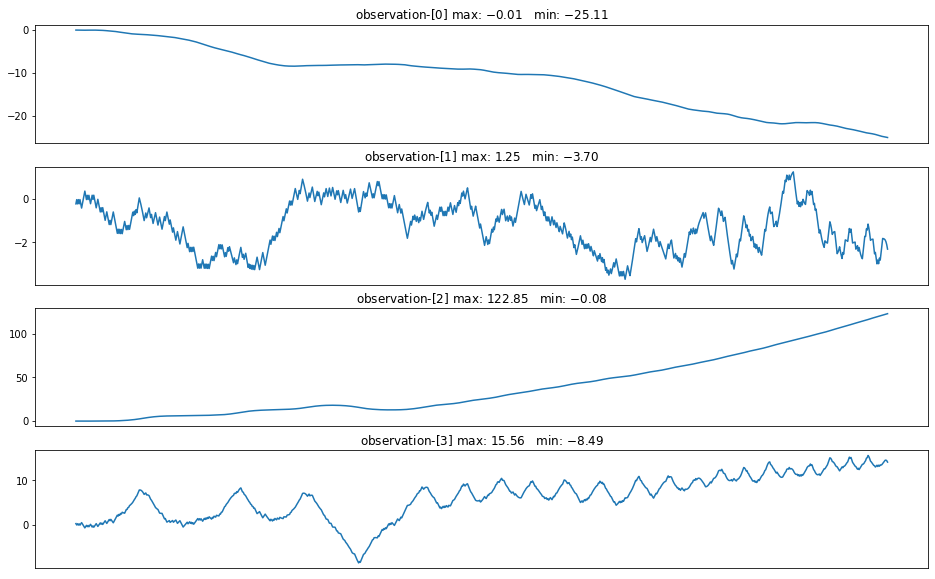

In [9]:
#一个demo试运行实验环境
import gym # 导入接口环境包
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0') #构建实验环境
env.reset()

print("----------连续的状态变量----------")
# 打印范围信息
print('High: ',env.observation_space.high,
     '\nLow: ',env.observation_space.low)

ob_list = []

for _ in range(1000):
    env.render() #显示图形界面
    s_t, reward, done, *info = env.step(env.action_space.sample()) # take a random action
    
    ob_list.append(np.take(s_t,[0,1,2,3]))
env.close() #关闭环境

# 打印随机运动时，移动速度和杆子偏转角速度的变化。
ob_arr = np.stack(ob_list)
fig, axes = plt.subplots(4, 1, figsize=(16, 10))
for i in range(4):
    axes[i].plot(ob_arr[:, i])
    max_ = ob_arr[:, i].max()
    min_ = ob_arr[:, i].min()
    x = i
    axes[i].set_title(f'observation-[{x}] max: ${max_:.2f}$   min: ${min_:.2f}$')
    axes[i].set_xticks([])

plt.show()

### 2.2 导入相关软件包

In [1]:
import numpy as np
import gym
import time
import random
import matplotlib.pyplot as plt

### 2.3 Config相关参数配置

In [2]:
env = gym.make('CartPole-v0').unwrapped #载入env
episode = 100000 #最多epoch数
max_number_of_steps = 200 #一场游戏的最高分
goal_average_steps = 195 #训练结束条件（近100场平均得分高于195）
num_iteration = 100 #近100场
lr = 0.09 #学习率
GAMMA = 0.99 #衰减因子
s_split_num = 4 #离散化分区块数
epsilon = 0.9
#状态信息四个量的分区依据
low = [-2.4, -3.0, -0.5, -2.0] 
high = [2.4, 3.0, 0.5, 2.0]

/Users/ll/opt/anaconda3/envs/py3_9/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


## 3. environment类
本封装类主要对env返回的值进行处理，包含以下两个方法

```__decode(self,state)```: 对state值进行离散化编码，返回对应state的编码值

```step(self,action)```: 采取动作action在env中运行一步，返回新的状态信息

In [3]:
class Environment:
    def __init__(self, env, low, high, s_split_n):
        #high和low分别存状态信息取值的最大和最小值
        self.env = env
        self.low = low
        self.high =high
        self.s_split_n = s_split_n
    
    #对连续的state进行离散化编码，返回一个state_code编码值
    def __decode(self, state):
        st_decode = []
        for i in range(len(state)):
            split_sec = np.linspace(self.low[i],self.high[i],self.s_split_n+1)[1:-1]
            idx = np.digitize(state[i], split_sec) #得到该值所属区间块
            st_decode.append(idx)
        return np.array(st_decode)
    
    #采取动作action，游戏运行一步，并返回(状态、奖励、是否死亡、调试信息)
    def step(self, action):
        s_t, reward, done, *info = self.env.step(int(action))
        s_t_code = self.__decode(s_t)
        return s_t_code, reward, done, info[0]

## 4. Qtable

Q-Learning和SARSA的核心都是建立一张state-action的表格，表格中每一格表示某个状态下采取某个策略时得到的reward。在本问题CartPole-v0下的env，action只有两种，分别对应左移和右移。

### 4.1 连续状态进行离散化处理

由于CartPole-V0返回的状态的四个值是连续值，Q表格的行数非有限。因此，需要先对状态进行离散化处理。以状态中移动速度为例子，移动速度的取值范围是[-3.4028235e+38,3.4028235e+38]，而大部分移动速度值在[-3.0,3.0]，因此，先把移动速度的取值区间限定在[-3.0,3.0]。然后，将区间[-3.0,3.0]平均分成n份，则包括上小于-3和大于-3，移动速度的取值区间分成了n+2个子区间。最后，将移动速度的值离散化到对应的区间块中。

### 4.2 方法
```__cal_state_idx``` ：计算当前状态所属分区块的下标

```get_Q(self, state_code, action)``` ：获得当前状态下执行action后得到的Q

```get_best_action(self, state_code)``` ：获得当前状态下能够得到最大Q对应的动作

```get_max_Q(self, state_code)``` ：获得当前状态下能够获得的最大Q的值

```udpate_ql(self, *)``` ：使用Q-learning的公式更新Qtable

```udpate_sarsa(self, *)``` ：使用Q-learning的公式更新Qtable

### 3.3 更新Qtable公式

初始时，用随机数初始化Q表格。

#### 3.3.1 SARSA方法

SARSA基于on-policy策略，通过$\epsilon-greedy$策略对Q进行更新，具体公式表示如下：

$$Q(s_t,a_t)=Q(s_t,a_t)+\alpha [r+\gamma  Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]$$

#### 3.3.2 Q-learning方法

Q-learning基于off-policy策略，选取最优动作对Q进行更新，具体公式表示如下：

$$Q(s_t,a_t)=Q(s_t,a_t)+\alpha [r+\gamma  max_{a^{\prime}}Q(s^{\prime},a^{\prime})-Q(s_t,a_t)]$$

In [4]:
class Qtable:
    def __init__(self, action_n=2, state_n=4, s_split_n=4):
        #可选动作数=2
        self.action_n = action_n
        #区间分割数
        self.s_split_n = s_split_n
        #随机初始化Qtable
        self.table = np.random.uniform(
            low=0, high=1, size=(s_split_n**state_n, action_n))
        
    # 每个状态信息对应的区间idx转换到q表格上
    def __cal_state_idx(self, state_code):
        idx = 0
        length = len(list(state_code))
        for i in range(length):
            idx += state_code[length-i-1] * (self.s_split_n**i)
        return idx
    
    #更新表格
    #SARSA
    def update_sarsa(self, state_code, action, reward, lr, GAMMA, state_t1):
            #计算横坐标编码后state的idx
            idx = self.__cal_state_idx(state_code)
            idx_t1 = self.__cal_state_idx(state_t1)
            next_action = self.get_best_action(state_t1)
            delta = reward + GAMMA*self.get_Q(state_t1,next_action) - self.table[idx,action]
            self.table[idx, action] += lr * delta
            return delta
    #Q-learning
    def update_ql(self, state_code, action, reward, lr, GAMMA, max_q_next):
        #计算横坐标编码后state的idx
        idx = self.__cal_state_idx(state_code)
        delta = reward + GAMMA*max_q_next - self.table[idx,action]
        self.table[idx, action] += lr * delta
        return delta
    
    #返回state_code的状态下执行动作action后得到的Q
    def get_Q(self, state_code, action):
        idx = self.__cal_state_idx(state_code)
        return self.table[idx, action]
    
    #返回state_code状态下能够得到最大Q对应的动作
    def get_best_action(self, state_code):
        idx = self.__cal_state_idx(state_code)
        return np.argmax(self.table[idx])
    
    #返回state_code状态能获得的最大Q值
    def get_max_Q(self, state_code):
        idx = self.__cal_state_idx(state_code)
        return float(np.max(self.table[idx]))

## 5. train类
在Train封装类里进行模型的训练，包含以下两个方法：

```choose_action(self, epsilon, s_t_code)```：通过epsilon的值决定当前action基于探索还是深挖，即选择随机动作或基于q表格获得当前最优动作。

```train_model(self)```：训练模型

In [5]:
class Train:
    def __init__(self, episode, env, lr, GAMMA, s_split_n, high, low,
                max_number_of_steps, goal_average_steps, num_iteration,epsilon):
        self.episode = episode
        self.env =env
        self.lr =lr
        self.GAMMA = GAMMA
        self.s_split_n = s_split_n
        self.high = high
        self.low = low
        self.max_number_of_steps = max_number_of_steps
        self.goal_average_steps = goal_average_steps
        self.num_iteration = num_iteration
        self.epsilon = epsilon
        
        self.Q_table = Qtable(action_n=env.action_space.n, 
                              state_n=env.observation_space.shape[0], 
                              s_split_n=s_split_n)
        self.envir = Environment(env=env,low=low,
                                 high=high,s_split_n=s_split_n)
        
    def choose_action(self, epsilon, s_t_code):
        # action选择
        # 随着epoch增加epsilon变小，探索过程减少，逐渐收敛到最优
        if np.random.random() <= epsilon:
            # exploration，探索过程随机动作
            return self.env.action_space.sample()
        else:
            # explotation， 挖掘过程选择能获得最大Q值的动作
            return self.Q_table.get_best_action(s_t_code)
        
    def train_model(self):
        #存储最近100场的得分
        last_time_reward = np.zeros(self.num_iteration)
        #存储每个epoch的步数
        step_num_list=[]
        #存储每个epoch的reward
        step_reward_list=[]
        #存储每次更新Q表格误差
        step_error_list=[]
        epsilon = self.epsilon
        for e in range(self.episode):
            # 计时
            start = time.time()
            #epsilon随着epoch增加而减少
            epsilon = epsilon*0.9
            # 初始化环境
            self.env.reset()
            self.env.render()
            epoch_reward = 0
            if e==0:
                # 第一轮随机从动作空间中选择一个动作
                action = self.env.action_space.sample()
            else:
                action = self.choose_action(epsilon,s_t_code)
            s_t_code, reward, done, info = self.envir.step(action)
            step_num = 0
            for _ in range(200):
                step_num += 1
                # 环境渲染画面
                self.env.render()
                
                #action选择
                action = self.choose_action(epsilon, s_t_code)
                
                #返回新的状态
                s_t1_code, reward, done, info = self.envir.step(action)
                
                #游戏提前死亡，最后一轮扣200分
                if done:
                    reward = -200
                #游戏仍存活，每次reward=1
                else:
                    reward = 1
                
                epoch_reward += reward
                
                #更新Q表格和当前状态
                max_q_next = self.Q_table.get_max_Q(s_t1_code)
                
                #sarsa
                delta = self.Q_table.update_sarsa(state_code=s_t_code, action=action,
                            reward=reward, lr=self.lr,
                            GAMMA=self.GAMMA, state_t1=s_t1_code)
                #Q-learning
#                 delta = self.Q_table.update_ql(state_code=s_t_code, action=action,
#                             reward=reward, lr=self.lr,
#                             GAMMA=self.GAMMA, max_q_next=max_q_next)
                step_error_list.append(delta)
                s_t_code = s_t1_code
                if done:
                    break
            # 单个epoch计时结束
            end = time.time()
            last_time_reward = np.hstack((last_time_reward[1:],[epoch_reward]))
            step_num_list.append(step_num)
            step_reward_list.append(epoch_reward)
            
            #打印当前epoch信息
            print('Epoch:{0:d}'.format(e),
                 '  time:{0:.4f}'.format(end-start),
                 '  step_num:{0:d}'.format(step_num),
                 '  reward:{0:4f}'.format(epoch_reward))
            
            #判断是否符合训练结束条件
            if(last_time_reward.mean() >= self.goal_average_steps):
                print('training successfully')
                np.save('step_num_'+str(e)+'.npy', np.array(step_num_list))
                np.save('step_reward_'+str(e)+'.npy',np.array(step_reward_list))
                np.save('step_error_'+str(e)+'.npy',np.array(step_error_list))
                break
                

## 6. 开始训练

### 6.1 SARSA方法进行训练

最终训练**348**个epoch达成结束条件，即最后100轮游戏平均reward>=195。

In [177]:
# lr=0.09 GAMMA=0.99 s_split_num=4
train = Train(episode=episode, env=env, lr=lr, GAMMA=GAMMA, 
              s_split_n=s_split_num, high=high, low=low, 
             max_number_of_steps=max_number_of_steps, 
              goal_average_steps=goal_average_steps, 
              num_iteration=num_iteration, epsilon=epsilon)
train.train_model()

Epoch:0   time:0.0108   step_num:13   reward:-188.000000
Epoch:1   time:0.0103   step_num:16   reward:-185.000000
Epoch:2   time:0.0061   step_num:11   reward:-190.000000
Epoch:3   time:0.0147   step_num:34   reward:-167.000000
Epoch:4   time:0.0054   step_num:12   reward:-189.000000
Epoch:5   time:0.0036   step_num:8   reward:-193.000000
Epoch:6   time:0.0070   step_num:18   reward:-183.000000
Epoch:7   time:0.0059   step_num:16   reward:-185.000000
Epoch:8   time:0.0039   step_num:10   reward:-191.000000
Epoch:9   time:0.0093   step_num:29   reward:-172.000000
Epoch:10   time:0.0280   step_num:97   reward:-104.000000
Epoch:11   time:0.0567   step_num:200   reward:200.000000
Epoch:12   time:0.0407   step_num:143   reward:-58.000000
Epoch:13   time:0.0346   step_num:116   reward:-85.000000
Epoch:14   time:0.0186   step_num:61   reward:-140.000000
Epoch:15   time:0.0173   step_num:58   reward:-143.000000
Epoch:16   time:0.0236   step_num:81   reward:-120.000000
Epoch:17   time:0.0351   

Epoch:145   time:0.0353   step_num:119   reward:-82.000000
Epoch:146   time:0.0346   step_num:120   reward:-81.000000
Epoch:147   time:0.0400   step_num:140   reward:-61.000000
Epoch:148   time:0.0564   step_num:200   reward:200.000000
Epoch:149   time:0.0440   step_num:155   reward:-46.000000
Epoch:150   time:0.0485   step_num:168   reward:-33.000000
Epoch:151   time:0.0458   step_num:161   reward:-40.000000
Epoch:152   time:0.0450   step_num:158   reward:-43.000000
Epoch:153   time:0.0517   step_num:180   reward:-21.000000
Epoch:154   time:0.0339   step_num:118   reward:-83.000000
Epoch:155   time:0.0425   step_num:147   reward:-54.000000
Epoch:156   time:0.0403   step_num:141   reward:-60.000000
Epoch:157   time:0.0338   step_num:118   reward:-83.000000
Epoch:158   time:0.0479   step_num:169   reward:-32.000000
Epoch:159   time:0.0270   step_num:93   reward:-108.000000
Epoch:160   time:0.0567   step_num:200   reward:200.000000
Epoch:161   time:0.0450   step_num:156   reward:-45.0000

Epoch:287   time:0.0572   step_num:200   reward:200.000000
Epoch:288   time:0.0566   step_num:200   reward:200.000000
Epoch:289   time:0.0564   step_num:200   reward:200.000000
Epoch:290   time:0.0565   step_num:200   reward:200.000000
Epoch:291   time:0.0573   step_num:200   reward:200.000000
Epoch:292   time:0.0567   step_num:200   reward:200.000000
Epoch:293   time:0.0566   step_num:200   reward:200.000000
Epoch:294   time:0.0565   step_num:200   reward:200.000000
Epoch:295   time:0.0573   step_num:200   reward:200.000000
Epoch:296   time:0.0568   step_num:200   reward:200.000000
Epoch:297   time:0.0565   step_num:200   reward:200.000000
Epoch:298   time:0.0466   step_num:164   reward:-37.000000
Epoch:299   time:0.0574   step_num:200   reward:200.000000
Epoch:300   time:0.0569   step_num:200   reward:200.000000
Epoch:301   time:0.0565   step_num:200   reward:200.000000
Epoch:302   time:0.0565   step_num:200   reward:200.000000
Epoch:303   time:0.0576   step_num:200   reward:200.0000

### 6.2 Q-learning方法进行训练

最终训练**304**个epoch达成结束条件，即最后100轮游戏平均reward>=195。

In [159]:
# lr=0.09 GAMMA=0.99 s_split_num=4
train = Train(episode=episode, env=env, lr=lr, GAMMA=GAMMA, 
              s_split_n=s_split_num, high=high, low=low, 
             max_number_of_steps=max_number_of_steps, 
              goal_average_steps=goal_average_steps, 
              num_iteration=num_iteration, epsilon=epsilon)
train.train_model()

Epoch:0   time:0.0319   step_num:60   reward:-141.000000
Epoch:1   time:0.0052   step_num:10   reward:-191.000000
Epoch:2   time:0.0063   step_num:14   reward:-187.000000
Epoch:3   time:0.0062   step_num:16   reward:-185.000000
Epoch:4   time:0.0097   step_num:28   reward:-173.000000
Epoch:5   time:0.0041   step_num:11   reward:-190.000000
Epoch:6   time:0.0137   step_num:45   reward:-156.000000
Epoch:7   time:0.0065   step_num:21   reward:-180.000000
Epoch:8   time:0.0079   step_num:26   reward:-175.000000
Epoch:9   time:0.0138   step_num:48   reward:-153.000000
Epoch:10   time:0.0031   step_num:8   reward:-193.000000
Epoch:11   time:0.0259   step_num:94   reward:-107.000000
Epoch:12   time:0.0304   step_num:109   reward:-92.000000
Epoch:13   time:0.0032   step_num:8   reward:-193.000000
Epoch:14   time:0.0198   step_num:71   reward:-130.000000
Epoch:15   time:0.0081   step_num:26   reward:-175.000000
Epoch:16   time:0.0042   step_num:12   reward:-189.000000
Epoch:17   time:0.0036   s

Epoch:145   time:0.0392   step_num:140   reward:-61.000000
Epoch:146   time:0.0119   step_num:40   reward:-161.000000
Epoch:147   time:0.0515   step_num:190   reward:-11.000000
Epoch:148   time:0.0533   step_num:196   reward:-5.000000
Epoch:149   time:0.0544   step_num:200   reward:200.000000
Epoch:150   time:0.0551   step_num:200   reward:200.000000
Epoch:151   time:0.0371   step_num:135   reward:-66.000000
Epoch:152   time:0.0541   step_num:200   reward:200.000000
Epoch:153   time:0.0341   step_num:123   reward:-78.000000
Epoch:154   time:0.0392   step_num:124   reward:-77.000000
Epoch:155   time:0.0561   step_num:200   reward:200.000000
Epoch:156   time:0.0323   step_num:116   reward:-85.000000
Epoch:157   time:0.0380   step_num:139   reward:-62.000000
Epoch:158   time:0.0352   step_num:129   reward:-72.000000
Epoch:159   time:0.0542   step_num:200   reward:200.000000
Epoch:160   time:0.0360   step_num:131   reward:-70.000000
Epoch:161   time:0.0476   step_num:172   reward:-29.00000

Epoch:285   time:0.0558   step_num:200   reward:200.000000
Epoch:286   time:0.0551   step_num:200   reward:200.000000
Epoch:287   time:0.0551   step_num:200   reward:200.000000
Epoch:288   time:0.0545   step_num:200   reward:200.000000
Epoch:289   time:0.0553   step_num:200   reward:200.000000
Epoch:290   time:0.0545   step_num:200   reward:200.000000
Epoch:291   time:0.0540   step_num:200   reward:200.000000
Epoch:292   time:0.0539   step_num:200   reward:200.000000
Epoch:293   time:0.0547   step_num:200   reward:200.000000
Epoch:294   time:0.0543   step_num:200   reward:200.000000
Epoch:295   time:0.0540   step_num:200   reward:200.000000
Epoch:296   time:0.0538   step_num:200   reward:200.000000
Epoch:297   time:0.0552   step_num:200   reward:200.000000
Epoch:298   time:0.0545   step_num:200   reward:200.000000
Epoch:299   time:0.0544   step_num:200   reward:200.000000
Epoch:300   time:0.0541   step_num:200   reward:200.000000
Epoch:301   time:0.0550   step_num:200   reward:200.0000

## 7. 打印训练过程

由训练过程可以看出，到最后100轮基本每局游戏都成功（达到200个回合未死亡），满足收敛条件。同时，随着epoch增加，Q表格的更新频次逐渐减少，说明模型更接近最优值。

### 7.1 SARSA方法下训练过程

训练时每局游戏运行步数-epoch


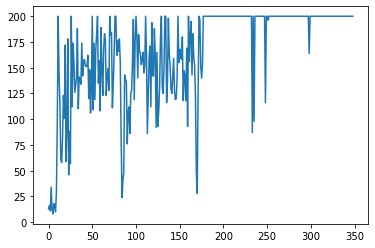

Q表格更新时的误差量-更新次数


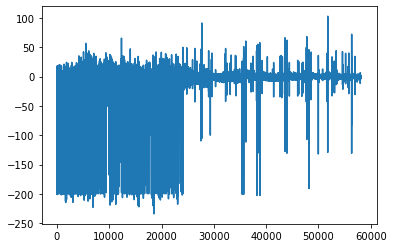

In [178]:
#加载文件
step_num_list = np.load('/Users/ll/code/enforcement/step_num_348.npy')
# step_reward_list = np.load('/Users/ll/code/enforcement/step_reward_374.npy')
step_error_list = np.load('/Users/ll/code/enforcement/step_error_348.npy')
# print pic
print("训练时每局游戏运行步数-epoch")
plt.plot(step_num_list)
plt.show()
print("Q表格更新时的误差量-更新次数")
plt.plot(step_error_list)
plt.show()

### 7.2 Q-learning方法下训练过程

训练时每局游戏运行步数-epoch


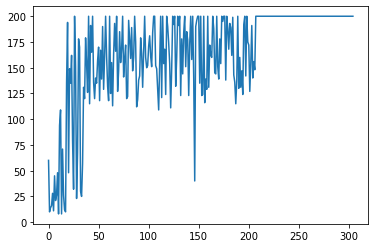

Q表格更新时的误差量-更新次数


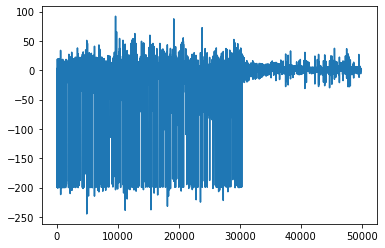

In [160]:
#加载文件
step_num_list = np.load('/Users/ll/code/enforcement/step_num_304.npy')
# step_reward_list = np.load('/Users/ll/code/enforcement/step_reward_374.npy')
step_error_list = np.load('/Users/ll/code/enforcement/step_error_304.npy')
# print pic
print("训练时每局游戏运行步数-epoch")
plt.plot(step_num_list)
plt.show()
print("Q表格更新时的误差量-更新次数")
plt.plot(step_error_list)
plt.show()